1. Load required packages

In [1]:
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly_calplot import calplot

import time
import random
import calmap
import warnings
warnings.filterwarnings('ignore')


sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [2]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


Machine Learning Process

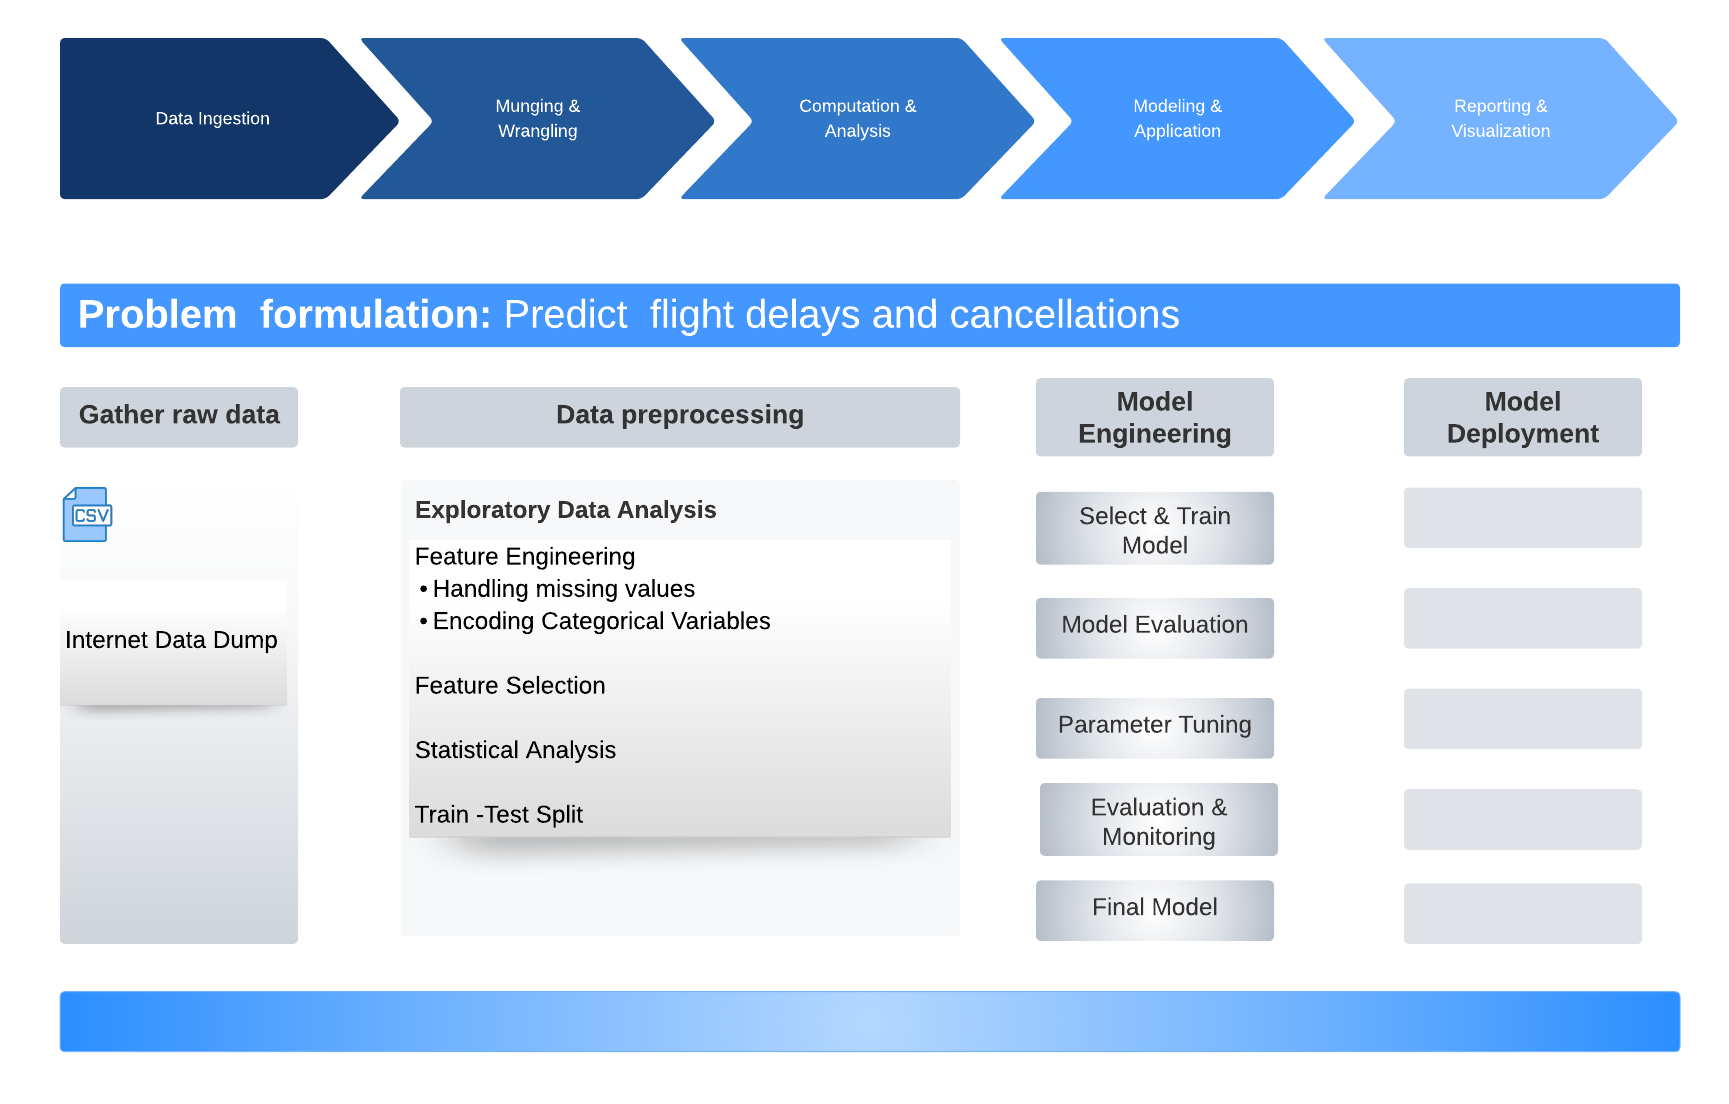

In [3]:
Image("../../data/images/MLProcess.png")

### Load in the data

In [4]:
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
df_flights = pd.read_csv("../../data/eda/flights/all_flight_data_20182022/all_flight_data_20182022.zip",skiprows=skip, low_memory=False)


In [5]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [6]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [7]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [8]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})



### Data Pre-processing Phase
- EDA
- Feature Engineering
  - Handling missing values
  - Encoding Categorical Variables
- Feature Selection 
- Statistical Analysis
- Train - Test Split

In [9]:
df_flights.dtypes

Unnamed: 0                                   int64
Year                                         int64
Quarter                                      int64
Month                                        int64
DayofMonth                                   int64
DayOfWeek                                    int64
FlightDate                                  object
Marketing_Airline_Network                   object
Operated_or_Branded_Code_Share_Partners     object
DOT_ID_Marketing_Airline                     int64
                                            ...   
Div5Airport                                float64
Div5AirportID                              float64
Div5AirportSeqID                           float64
Div5WheelsOn                               float64
Div5TotalGTime                             float64
Div5LongestGTime                           float64
Div5WheelsOff                              float64
Div5TailNum                                float64
Duplicate                      

In [10]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

def tweak_df_flights(df_flights):
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime",
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            #"Cancelled": "bool",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16"
        }
    )


df_flights = tweak_df_flights(df_flights)

##########Flight Status Categories####################
###############DepDelayGroups#########################
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Cancelled"
    
DepDelay_Class(df_flights)
df_flights["DepDelayClass"].astype("category")

# Handling Ordinal Categorical Variables [Label Encoding]
# assign the feature with ranks [Ordinal numbering encoding (Label Encoding)]
# engineer categorical variable by ordinal number replacement
DepDelayClass_mapping = {
    'OnTime': '1',
    'Delay15_45': '2',
    'Delay45_180': '3',
    'Cancelled': '4',
    }

df_flights["DepDelayClass_ordinal"] = df_flights.DepDelayClass.map(DepDelayClass_mapping)


print(df_flights.shape)
df_flights.tail()


(744664, 45)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,DepDelayClass_ordinal
744659,2022-08-31,Comair Inc.,N601EN,5293,11057,CLT,"Charlotte, NC",NC,North Carolina,12217,HSV,"Huntsville, AL",AL,Alabama,1813,1819.0,6.0,0.0,6.0,1800-1859,23.0,1837.0,4.0,1843,1841.0,0.0,0.0,1800-1859,0.0,none,False,90.0,55.0,333.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.21875,-80.9375,OnTime,1
744660,2022-08-29,Comair Inc.,N600NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,828.0,-6.0,0.0,0.0,0800-0859,14.0,944.0,5.0,1006,949.0,0.0,0.0,1000-1059,0.0,none,False,92.0,62.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625,OnTime,1
744661,2022-08-28,Comair Inc.,N566NN,5295,10994,CHS,"Charleston, SC",SC,South Carolina,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,742,736.0,-6.0,0.0,0.0,0700-0759,23.0,923.0,10.0,931,933.0,2.0,0.0,0900-0959,0.0,none,False,109.0,84.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.90625,-80.0625,OnTime,1
744662,2022-08-08,Comair Inc.,N559NN,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1714,1813.0,59.0,1.0,59.0,1700-1759,40.0,2014.0,6.0,1905,2020.0,75.0,1.0,1900-1959,0.0,none,False,111.0,81.0,524.0,5.0,0.0,16.0,0.0,54.0,0.0,0.0,38.84375,-77.0625,Delay45_180,3
744663,2022-08-19,Comair Inc.,N548NN,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1712,1727.0,15.0,1.0,15.0,1700-1759,16.0,1856.0,4.0,1906,1900.0,0.0,0.0,1900-1959,0.0,none,False,114.0,73.0,524.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625,OnTime,1


In [11]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744664 entries, 0 to 744663
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   FlightDate             744664 non-null  datetime64[ns]
 1   Operating_Airline      744664 non-null  category      
 2   Tail_Number            744664 non-null  category      
 3   Flight_Number          744664 non-null  int16         
 4   OriginAirportID        744664 non-null  int16         
 5   Origin                 744664 non-null  category      
 6   OriginCityName         744664 non-null  category      
 7   OriginState            744664 non-null  category      
 8   OriginStateName        744664 non-null  category      
 9   DestAirportID          744664 non-null  int16         
 10  Dest                   744664 non-null  category      
 11  DestCityName           744664 non-null  category      
 12  DestState              744664 non-null  cate

Feature Selection 

In [12]:
#df_flights.columns.to_list()

In [13]:
####Feature Selection#####
ml_cols = [
    'FlightDate',
    'Operating_Airline',
    'Tail_Number',
    'Flight_Number',
    'OriginAirportID',
    #'Origin',
    #'OriginCityName',
    #'OriginState',
    #'OriginStateName',
    'DestAirportID',
    #'Dest',
    #'DestCityName',
    #'DestState',
    #'DestStateName',
    'CRSDepTime',
    'DepTime',
    #'DepDelay',
    #'DepDel15',
    'DepDelayMinutes',
    #'DepTimeBlk',
    'TaxiOut',
    'WheelsOn',
    'TaxiIn',
    'CRSArrTime',
    #'ArrTime',
    #'ArrDelayMinutes',
    #'ArrDel15',
    #'ArrTimeBlk',
    'Cancelled',
    #'CancellationCode',
    #'Diverted',
    'CRSElapsedTime',
    'AirTime',
    'Distance',
    #'CarrierDelay',
    #'WeatherDelay',
    #'NASDelay',
    #'SecurityDelay',
    #'LateAircraftDelay',
    #'FirstDepTime',
    'TotalAddGTime',
    'latitude',
    'longitude',
    'DepDelayClass',
    ]

df_flights_2= df_flights[ml_cols]
df_flights_2.columns

Index(['FlightDate', 'Operating_Airline', 'Tail_Number', 'Flight_Number',
       'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'TaxiOut', 'WheelsOn', 'TaxiIn', 'CRSArrTime',
       'Cancelled', 'CRSElapsedTime', 'AirTime', 'Distance', 'TotalAddGTime',
       'latitude', 'longitude', 'DepDelayClass'],
      dtype='object')

Statistical Analysis
- Flights per airline
- Distribution of flight delays by year
- Distribution of flight delays by airline
- Distribution of flight cancellations by airline
- Most reliable airline (on time)

In [14]:
#Flights per airline
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Number of Flights per airline",
    height=700,
)

Text(0.5, 0, 'Number of Flights ')

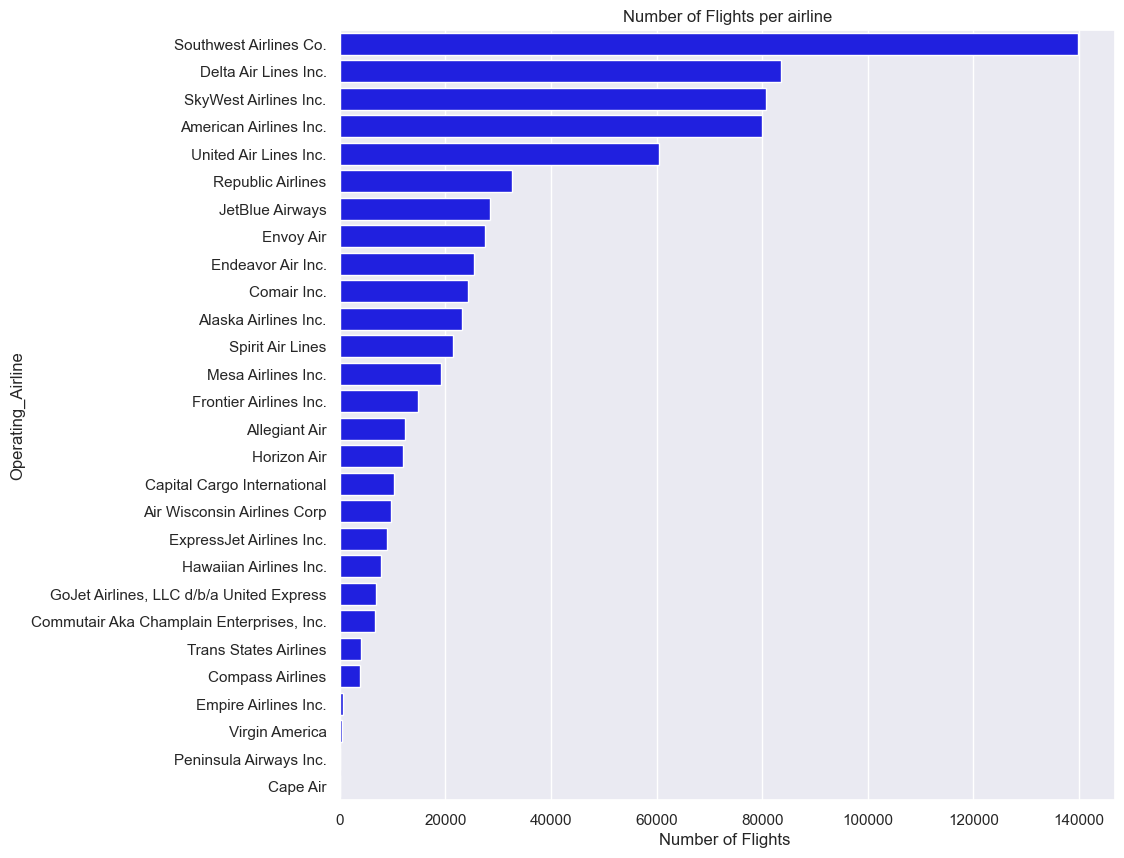

In [15]:
fig,ax = plt.subplots(figsize=(10,10))
sorted_airlines = df_flights["Operating_Airline"].value_counts().index.tolist()
sns.countplot(y=df_flights["Operating_Airline"], order=sorted_airlines, color='blue')
ax.set_title("Number of Flights per airline")
ax.set_xlabel("Number of Flights ")

In [16]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays"
              )
fig.show()


In [17]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays by airline"
              )
fig.show()

In [18]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations"
              )
fig.show()

In [19]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations by airline",
              height=700
              )
fig.show()

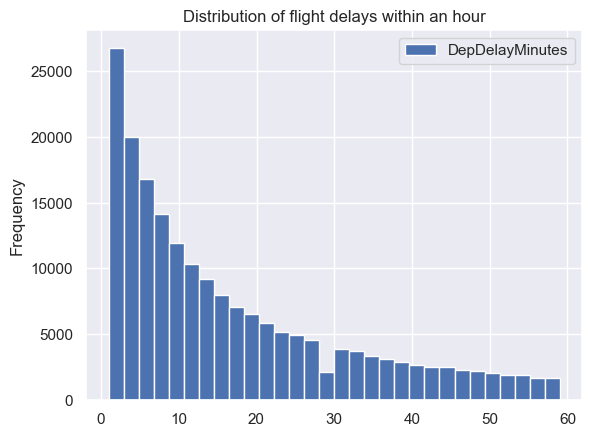

In [20]:
(df_flights
 .query("DepDelayMinutes > 0 and DepDelayMinutes < 60")
 [["DepDelayMinutes"]]
 .plot(kind="hist", bins=30, title="Distribution of flight delays within an hour"))
plt.show()


In [21]:
df_flights_2.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,Cancelled,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude,DepDelayClass
0,2018-01-23,Endeavor Air Inc.,N8928A,3298,10397,10146,1037,1032.0,0.0,19.0,1129.0,4.0,1137,0.0,60.0,38.0,145.0,0.0,33.62500,-84.4375,OnTime
1,2018-01-21,Endeavor Air Inc.,N8683B,3300,10785,11433,1240,1238.0,0.0,27.0,1437.0,9.0,1455,0.0,135.0,92.0,537.0,0.0,44.46875,-73.1250,OnTime
2,2018-01-25,Endeavor Air Inc.,N686BR,3301,11617,10397,1415,1403.0,0.0,12.0,1531.0,5.0,1605,0.0,110.0,76.0,433.0,0.0,35.06250,-77.0625,OnTime
3,2018-01-30,Endeavor Air Inc.,N835AY,3302,10397,11641,1708,1700.0,0.0,20.0,1820.0,6.0,1828,0.0,80.0,60.0,331.0,0.0,33.62500,-84.4375,OnTime
4,2018-01-14,Endeavor Air Inc.,N326PQ,3302,13487,15016,850,847.0,0.0,17.0,1006.0,7.0,1040,0.0,110.0,62.0,448.0,0.0,44.87500,-93.1875,OnTime


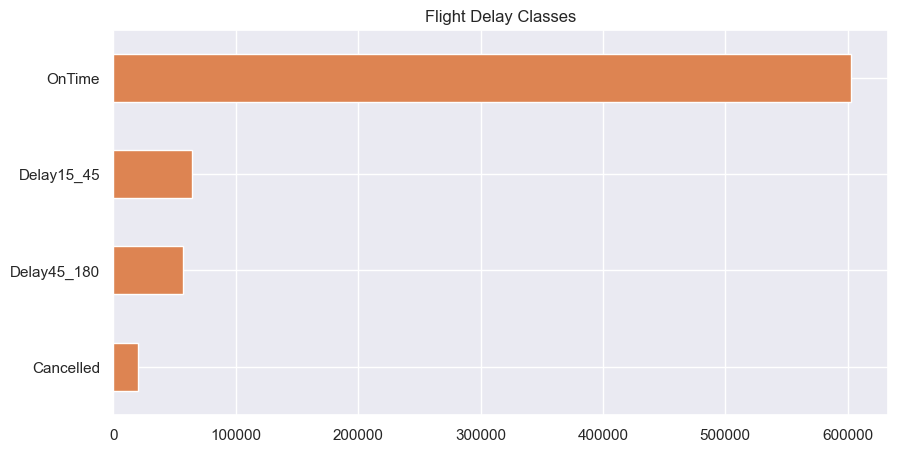

In [22]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes")
 )
plt.show()

Percentage of flights per year 

In [23]:
df_flights["Year"] = df_flights["FlightDate"].dt.year
df_flights_agg = df_flights.groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.527988,9.532644,8.226165,80.713202
2019,1.939504,9.047718,8.650810,80.361968
2020,6.139110,4.567568,3.733704,85.559618
2021,1.774232,8.947889,7.595338,81.682540
2022,2.879543,10.987260,9.609272,76.523925


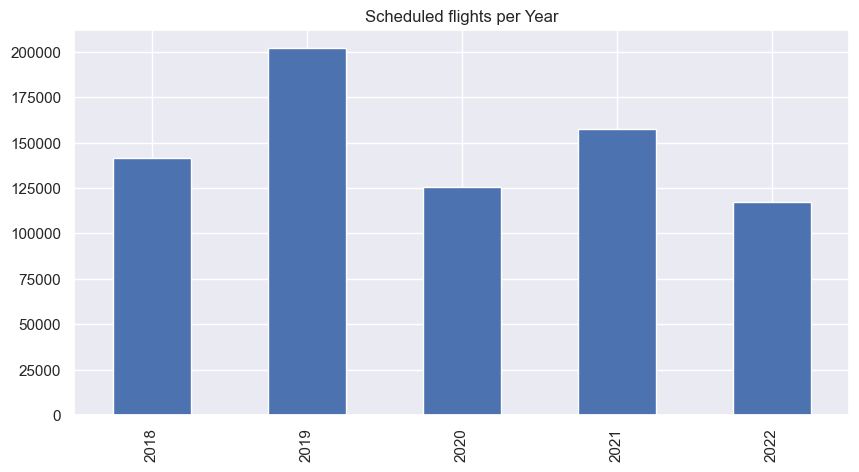

In [24]:
df_flights["Year"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per Year")
plt.show()

In [25]:
px.bar(
    df_flights["Year"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='v',
    template="plotly_dark",
    title="Scheduled flights per year",
    height=700,
)

Percentage of Flights by Month

In [26]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,3.001971,7.856095,6.909274,82.232660
2,3.200095,8.830427,7.644200,80.325278
3,5.573117,7.501068,6.206749,80.719066
4,6.963960,7.832079,6.914851,78.289109
5,1.968170,8.929723,7.926974,81.175133
6,1.996725,10.979503,10.456749,76.567023
7,1.668305,9.914499,10.023237,78.393958
8,2.182278,9.640500,9.258531,78.918691
9,1.455036,6.697177,5.694333,86.153453


- Why the high cancellations in March - April?
- Lets analyse per year for these months 

In [27]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("3 <= Month <= 4").groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.539283,9.463922,7.332233,81.664562
2019,2.116261,8.515361,7.935239,81.433138
2020,25.133937,3.276161,2.805936,68.783966
2021,0.951936,5.809358,4.368705,88.870001
2022,1.806841,10.742737,9.413878,78.036544


The analysis shows that the majority of cancellations happened in 2020 March -April 2020, which was when we had covid-19

- How about the situation without 2020?

In [28]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("Year != 2020").groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,3.553857,8.032931,7.207684,81.205528
2,3.989091,9.524360,8.003605,78.482944
3,1.682861,8.619673,7.132670,82.564795
4,1.649003,8.808668,7.743383,81.798946
5,1.546420,9.500231,8.452656,80.500693
6,2.168414,11.729232,11.346140,74.756214
7,1.794343,10.883835,11.143634,76.178187
8,2.336617,10.586772,10.318421,76.758190
9,1.574038,7.330397,6.298312,84.797254


  Observations
  - Without the year 2020 when covid-19 was at its peak, we see that most cancellations happened in the months of January and February, this would be due to the weather
    - Winter: December, January, February
    - Spring: March, April, May
    - Summer: June, July, August
    - Autumn: September, October, November

Lets group by Month and Year analyse the cancellations

In [29]:
df_flights_agg = df_flights.query("Cancelled > 0").groupby(["Month", "Year"]).size().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

Year,2018,2019,2020,2021,2022
Month,,,,,
1,345.000000,501.000000,213.000000,113.000000,854.000000
2,126.000000,465.000000,157.000000,526.000000,609.000000
3,203.000000,322.000000,3029.000000,151.000000,209.000000
4,114.000000,393.000000,3492.000000,73.000000,324.000000
5,110.000000,382.000000,323.000000,50.000000,295.000000
6,101.000000,387.000000,24.000000,234.000000,461.000000
7,157.000000,355.000000,84.000000,268.000000,256.000000
8,268.000000,333.000000,126.000000,456.000000,371.000000
9,245.000000,298.000000,69.000000,186.000000,nan


(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot: ylabel='2018'>, <AxesSubplot: ylabel='2019'>,
        <AxesSubplot: ylabel='2020'>, <AxesSubplot: ylabel='2021'>,
        <AxesSubplot: ylabel='2022'>], dtype=object))

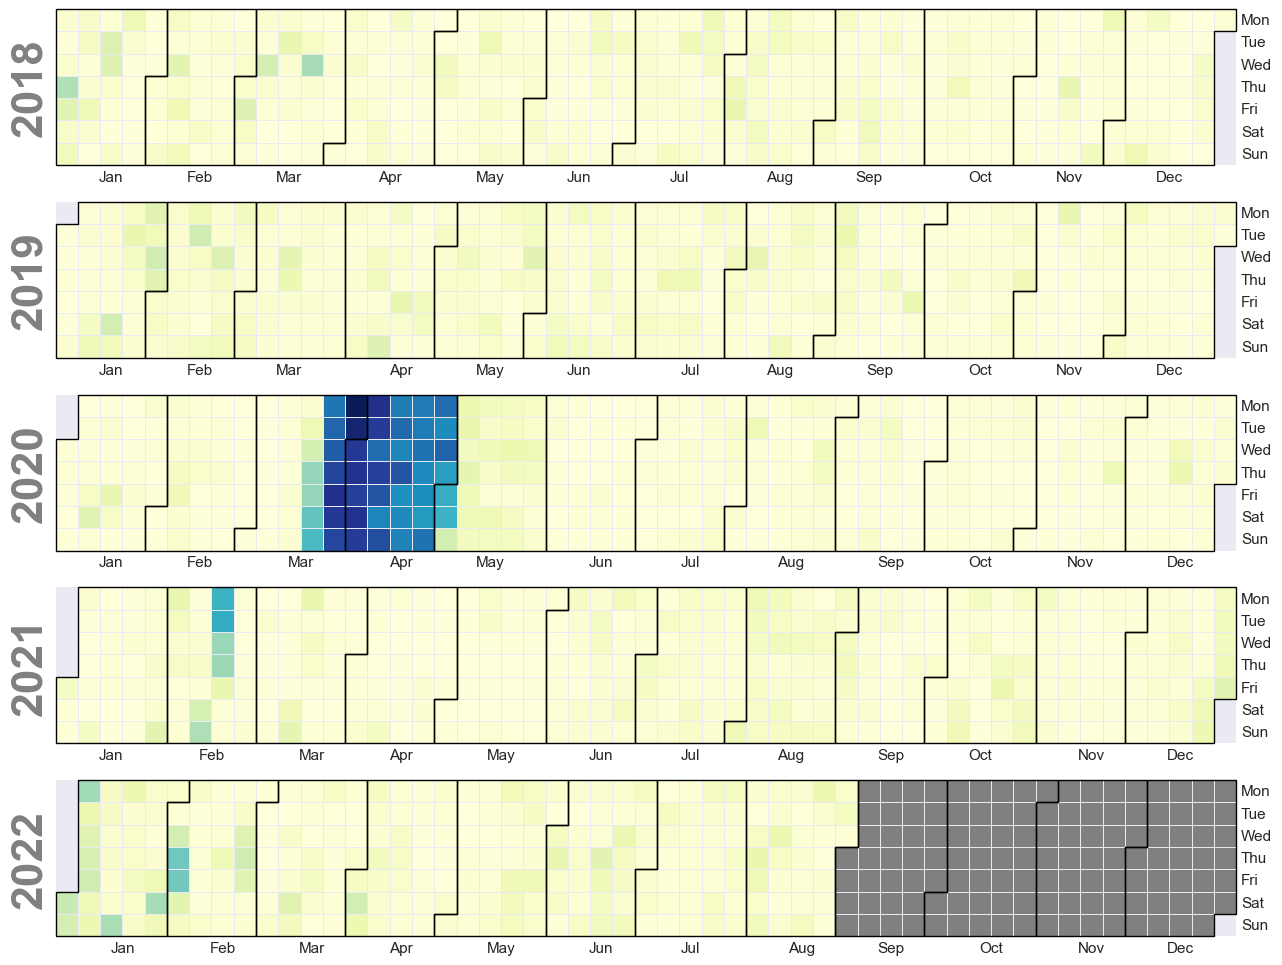

In [30]:
events = df_flights.groupby("FlightDate")["Cancelled"].mean()
calmap.calendarplot(events, monthticks=3, daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                    dayticks=True, cmap='YlGnBu',
                    fillcolor='grey', linewidth=0.5, monthly_border=True, 
                    fig_kws=dict(figsize=(20, 10)))

In [31]:
fig = calplot(
         events.reset_index(),
         x="FlightDate",
         y="Cancelled",
         colorscale="Reds",
         years_title=True
)
fig.show()

In [32]:
df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Operating_Airline,,,,
Air Wisconsin Airlines Corp,0.040037,0.061294,0.091425,0.807244
Alaska Airlines Inc.,0.019610,0.082277,0.055081,0.843031
Allegiant Air,0.043194,0.109678,0.097913,0.749214
American Airlines Inc.,0.031697,0.087820,0.081823,0.798661
Cape Air,0.000000,0.000000,0.000000,1.000000
Capital Cargo International,0.036305,0.062139,0.071925,0.829631
Comair Inc.,0.032372,0.073653,0.079838,0.814137
"Commutair Aka Champlain Enterprises, Inc.",0.039710,0.085913,0.137098,0.737279
Compass Airlines,0.017428,0.071561,0.078954,0.832057


<AxesSubplot: ylabel='Operating_Airline'>

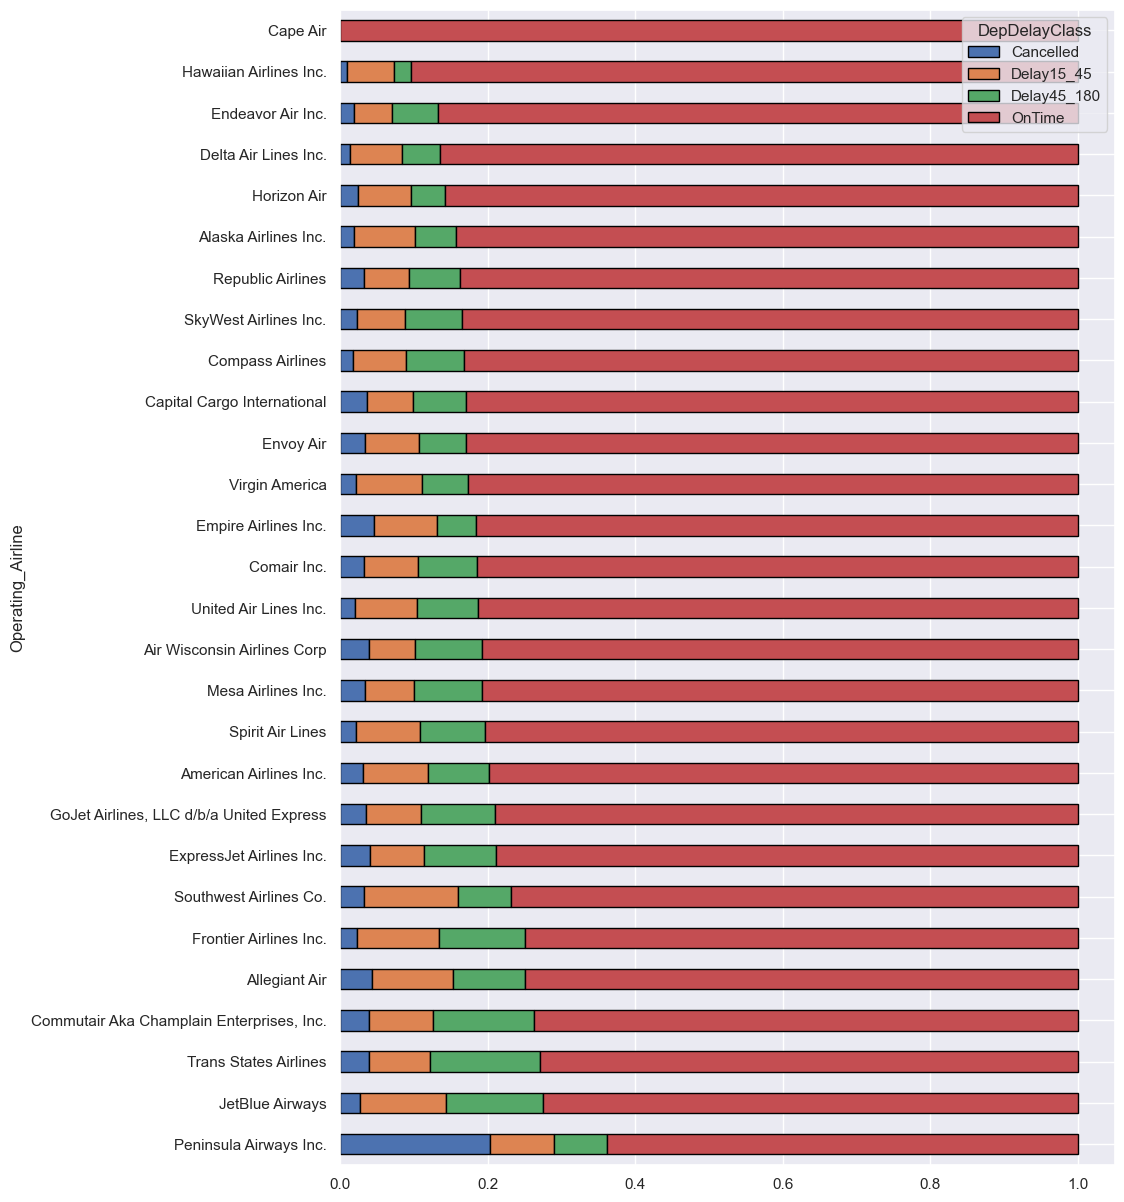

In [33]:
stacked_df_flights = df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()
stacked_df_flights.sort_values("OnTime").plot(kind='barh', figsize=(10,15), stacked=True, edgecolor="black")

In [34]:
fig = px.bar(stacked_df_flights.sort_values("OnTime"), barmode='stack', height=700, orientation='h')
fig.show()


#### Correlation [Pearson]

In [35]:
corr = (df_flights_2
        .select_dtypes('float16')
        .corr())
corr.style.background_gradient(cmap='coolwarm')


,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude
DepTime,1.000000,0.125263,0.115913,0.731818,0.044299,-0.015620,0.077679,-0.007579,0.019657,-0.031559,-0.004156
DepDelayMinutes,0.125263,1.000000,0.065329,0.035804,0.026589,0.014802,0.018335,0.011168,0.216609,-0.002068,0.027183
TaxiOut,0.115913,0.065329,1.000000,0.137025,0.075889,0.070411,0.106363,0.032098,0.026397,0.083744,0.102001
WheelsOn,0.731818,0.035804,0.137025,1.000000,0.074065,0.024471,0.123234,0.025715,-0.016916,-0.015471,-0.001981
TaxiIn,0.044299,0.026589,0.075889,0.074065,1.000000,0.098973,0.120532,0.068204,0.001360,-0.001107,0.050076
CRSElapsedTime,-0.015620,0.014802,0.070411,0.024471,0.098973,1.000000,0.946752,0.982241,0.007877,-0.040976,-0.028478
AirTime,0.077679,0.018335,0.106363,0.123234,0.120532,0.946752,1.000000,0.943319,-0.005966,-0.056422,-0.058527
Distance,-0.007579,0.011168,0.032098,0.025715,0.068204,0.982241,0.943319,1.000000,0.003437,-0.075077,-0.121562
TotalAddGTime,0.019657,0.216609,0.026397,-0.016916,0.001360,0.007877,-0.005966,0.003437,1.000000,0.007857,0.019704
latitude,-0.031559,-0.002068,0.083744,-0.015471,-0.001107,-0.040976,-0.056422,-0.075077,0.007857,1.000000,0.008079


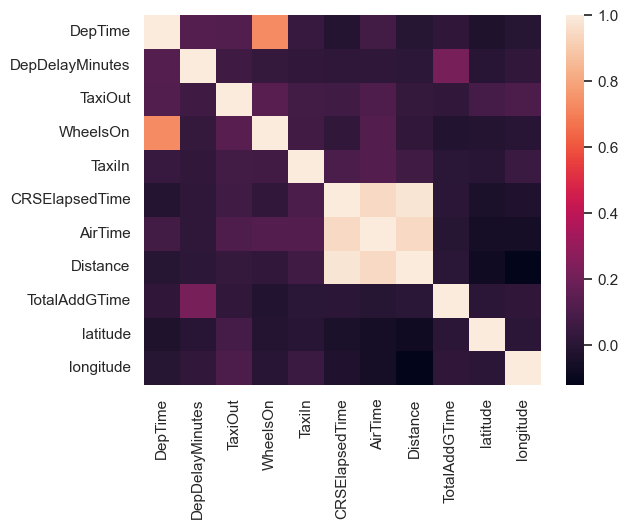

In [36]:
sns.heatmap(
    (df_flights_2
     .select_dtypes('float16')
     .corr()))
plt.show()


In [37]:
# Factors affecting delay
# Assumption: A flight is counted as "on time" if it operated less than 15 minutes later than the
def flight_status(df_flights):
        df_flights["FlightStatus"]="OnTime"

        df_flights.loc[df_flights["DepDel15"] == 0, "FlightStatus"]="OnTime"
        df_flights.loc[(df_flights["DepDelayMinutes"] >= 0) & (df_flights["DepDelayMinutes"] <= 15), "FlightStatus"]="OnTime"
        df_flights.loc[df_flights["WeatherDelay"] > 15, "FlightStatus"]="WeatherDelay"
        df_flights.loc[df_flights["NASDelay"] > 15, "FlightStatus"]="NASDelay"
        df_flights.loc[df_flights["SecurityDelay"] > 15, "FlightStatus"]="SecurityDelay"
        df_flights.loc[df_flights["LateAircraftDelay"] > 15, "FlightStatus"]="LateAircraftDelay"
        df_flights.loc[df_flights["CarrierDelay"] > 15, "FlightStatus"]="CarrierDelay"
        df_flights.loc[df_flights["Cancelled"], "FlightStatus"]="Cancelled"
    

flight_status(df_flights)

<AxesSubplot: xlabel='FlightDate'>

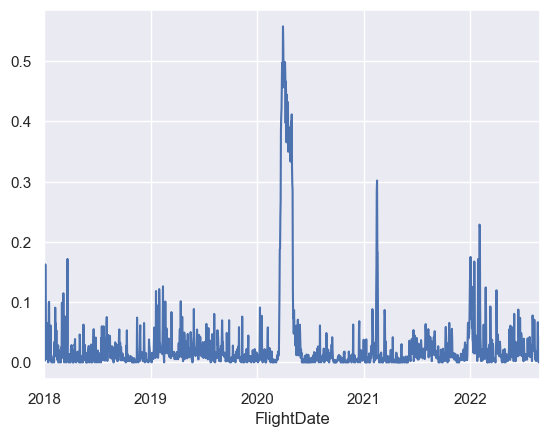

In [38]:
(df_flights.
 groupby("FlightDate")
 ["Cancelled"]
 .agg("mean")
 .plot()
 )


<AxesSubplot: xlabel='FlightDate'>

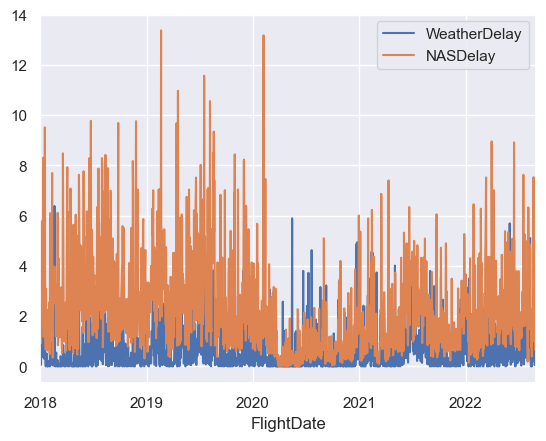

In [39]:
(df_flights.
 groupby("FlightDate")
 [["WeatherDelay", "NASDelay"]]
 .agg("mean")
 .plot())


<AxesSubplot: xlabel='FlightDate'>

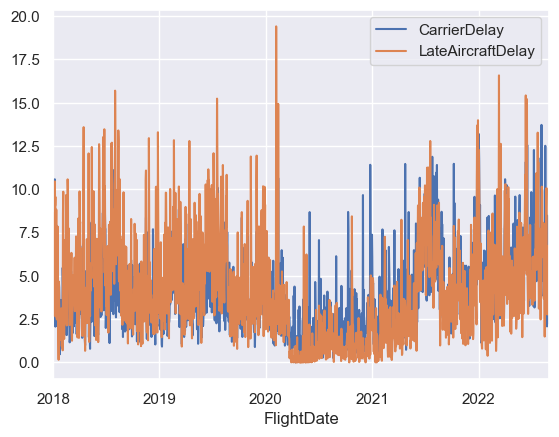

In [40]:
(df_flights.
 groupby("FlightDate")
 [["CarrierDelay", "LateAircraftDelay"]]
 .agg("mean")
 .plot())


##### Frequency Distribution Table

In [41]:
(df_flights
 [["Operating_Airline"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )


,Row Count
Operating_Airline,
Southwest Airlines Co.,139800
Delta Air Lines Inc.,83556
SkyWest Airlines Inc.,80683
American Airlines Inc.,80039
United Air Lines Inc.,60528
Republic Airlines,32532
JetBlue Airways,28512
Envoy Air,27501
Endeavor Air Inc.,25397


In [42]:
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Flights per airline",
    height=700,
)


In [43]:
df_flights.head(3)

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,DepDelayClass_ordinal,Year,Month,FlightStatus
0,2018-01-23,Endeavor Air Inc.,N8928A,3298,10397,ATL,"Atlanta, GA",GA,Georgia,10146,ABY,"Albany, GA",GA,Georgia,1037,1032.0,-5.0,0.0,0.0,1000-1059,19.0,1129.0,4.0,1137,1133.0,0.0,0.0,1100-1159,0.0,none,False,60.0,38.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.62500,-84.4375,OnTime,1,2018,1,Cancelled
1,2018-01-21,Endeavor Air Inc.,N8683B,3300,10785,BTV,"Burlington, VT",VT,Vermont,11433,DTW,"Detroit, MI",MI,Michigan,1240,1238.0,-2.0,0.0,0.0,1200-1259,27.0,1437.0,9.0,1455,1446.0,0.0,0.0,1400-1459,0.0,none,False,135.0,92.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.46875,-73.1250,OnTime,1,2018,1,Cancelled
2,2018-01-25,Endeavor Air Inc.,N686BR,3301,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1415,1403.0,-12.0,0.0,0.0,1400-1459,12.0,1531.0,5.0,1605,1536.0,0.0,0.0,1600-1659,0.0,none,False,110.0,76.0,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.06250,-77.0625,OnTime,1,2018,1,OnTime


In [44]:
(df_flights.
 groupby(["Flight_Number", "Tail_Number", "OriginCityName","DestCityName" ])
[["DepDelayMinutes"]]
#.agg(["mean", "sum"]).head(20)
)


In [45]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights
 .loc[df_flights["DepDelayMinutes"] >10, cols ]
 .sort_values(by=["Flight_Number", "FlightDate", "CRSDepTime"],ascending=[True, True, True]))

,FlightDate,Tail_Number,Flight_Number,Operating_Airline,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelayMinutes,AirTime,FlightStatus
8403,2018-01-05,N966JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1000,1216.0,136.0,158.0,CarrierDelay
56579,2018-07-17,N281WN,1,Southwest Airlines Co.,"Dallas, TX","Houston, TX",700,715.0,15.0,42.0,OnTime
64864,2018-08-01,N391HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,712.0,12.0,330.0,OnTime
141260,2018-12-03,N374HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,722.0,22.0,348.0,CarrierDelay
141261,2018-12-06,N393HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,816.0,76.0,328.0,CarrierDelay
161522,2019-02-05,N388HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,721.0,21.0,357.0,CarrierDelay
330475,2019-12-31,N370HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,732.0,32.0,286.0,OnTime
372968,2020-02-26,N676NK,1,Spirit Air Lines,"Fort Lauderdale, FL","Chicago, IL",2152,2300.0,68.0,153.0,NASDelay
393200,2020-03-20,N672NK,1,Spirit Air Lines,"Fort Lauderdale, FL","Chicago, IL",2152,19.0,147.0,161.0,NASDelay
513678,2021-05-01,N374HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,721.0,21.0,333.0,CarrierDelay


In [46]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights[cols]
 .groupby(["Flight_Number", "Operating_Airline"])
 [["DepDelayMinutes"]]
 .mean())

DepDelayMinutes
Flight_Number Operating_Airline                                         
1             Air Wisconsin Airlines Corp                            NaN
              Alaska Airlines Inc.                              0.200000
              Allegiant Air                                    51.599998
              American Airlines Inc.                            1.692308
              Cape Air                                               NaN
              Capital Cargo International                            NaN
              Comair Inc.                                            NaN
              Commutair Aka Champlain Enterprises, Inc.              NaN
              Compass Airlines                                       NaN
              Delta Air Lines Inc.                                   NaN
...                                                                  ...
9693          JetBlue Airways                                        NaN
              Mesa Airlines Inc.                                2.000000
              Peninsula Airways Inc.                                 NaN
              Republic Airlines                                      NaN
              SkyWest Airlines Inc.                                  NaN
              Southwest Airlines Co.                                 NaN
              Spirit Air Lines                                       NaN
              Trans States Airlines                                  NaN
              United Air Lines Inc.                                  NaN
              Virgin America                                         NaN

[198688 rows x 1 columns]

In [47]:
col2 = ["CarrierDelay","WeatherDelay",	"NASDelay",	"SecurityDelay","LateAircraftDelay", "FirstDepTime", "TotalAddGTime", "latitude", "longitude", "DepDelayClass"]
cols = ["FlightDate","CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]	

Modelling

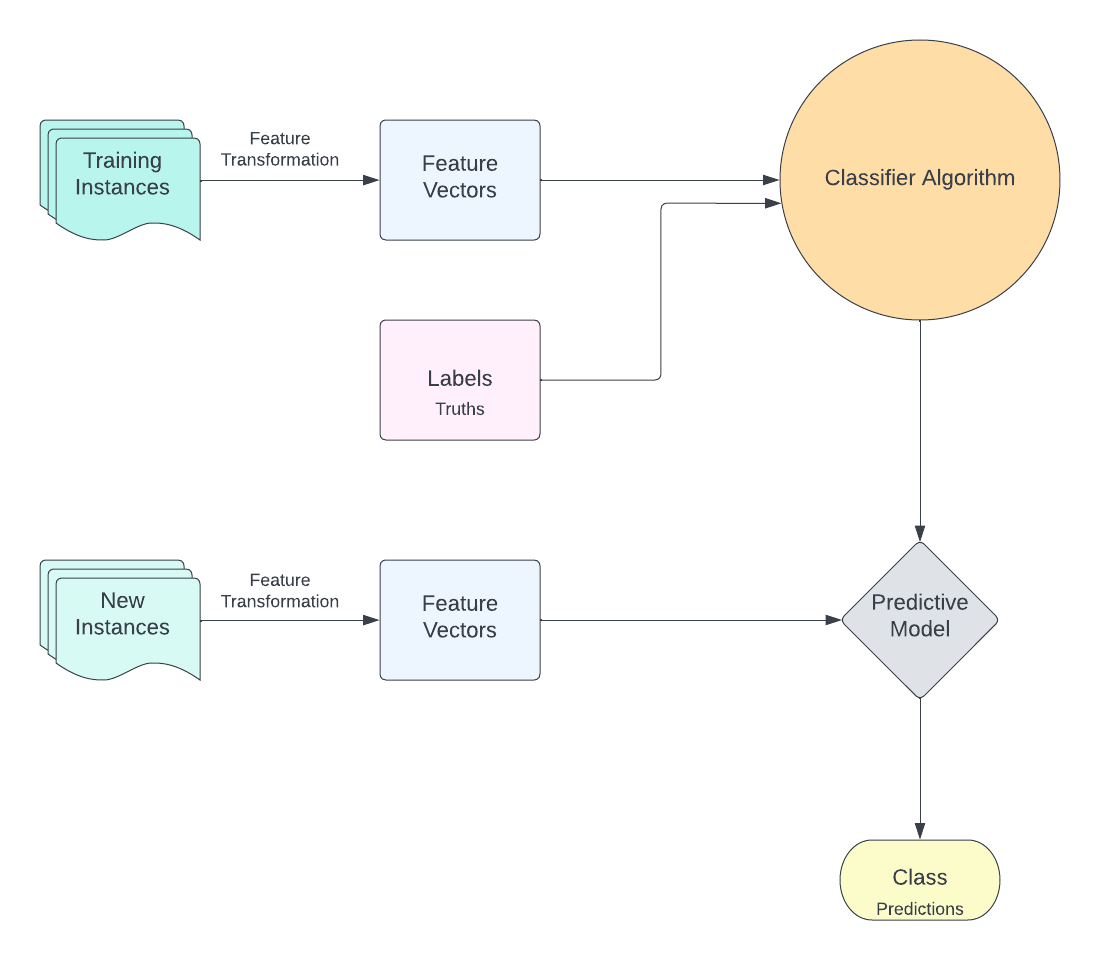

In [48]:
Image("../../data/images/ModellingWorkflow.png")

In [49]:
def fit_and_evaluate(X, y, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True)
    
    for train, test in kf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = model(**kwargs) 
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(X, y)